In [1]:
import copy
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from tqdm import tqdm

from options import args_parser
from utils import exp_details, get_dataset, average_weights
from update import LocalUpdate, test_inference
from models import MLP, CNNMnist, CNNFashion_Mnist, CNNCifar, AutoencoderMNIST
from sampling import dominant_label_sampling, dirichlet_sampling
from resnet import resnet20

In [2]:
def get_model(args, train_dataset, device):
    if args.supervision:
        # Supervised learning
        if args.model == "resnet":
            if args.dataset == "cifar":
                model = resnet20()
            else:
                exit("ResNet only implemented for CIFAR-10 dataset")
        elif args.model == "cnn":
            # Convolutional neural netork
            if args.dataset == "mnist":
                model = CNNMnist(num_channels=args.num_channels, num_classes=args.num_classes)
            elif args.dataset == "fmnist":
                model = CNNFashion_Mnist()
            elif args.dataset == "cifar":
                model = CNNCifar(num_classes=args.num_classes)

        elif args.model == "mlp":
            # Multi-layer preceptron
            img_size = train_dataset[0][0].shape
            len_in = 1
            for x in img_size:
                len_in *= x
            model = MLP(dim_in=len_in, dim_hidden=64, dim_out=args.num_classes)
        else:
            exit("Error: unrecognized model")
    else:
        # Self-supervised learning
        if args.model == "autoencoder":
            # Autoencoder with transpose convolutions
            if args.dataset == "mnist":
                model = AutoencoderMNIST(args=args)

        else:
            exit("Error: unrecognized unsupervised model")

    model.to(device)
    model.train()

    return model

In [3]:
import sys
sys.argv = ['', '--supervision', '--lr=0.00001', '--dataset=cifar', '--model=cnn']

# Parse, validate, and print arguments
args = args_parser()
exp_details(args)


Experimental details:

Reinforcement Arguments:
    Steps Before PPO Update : 256
    PPO Learning Rate       : 0.0003
    PPO Discount Factor     : 0.9
    PPO Batch Size          : 16
    PPO Total Timesteps     : 15000
    Target Accuracy         : 0.95

Federated Arguments:
    Number of Users         : 100
    Fraction of Users       : 0.1
    Local Epochs            : 1
    Local Batch Size        : 10
    Learning Rate           : 1e-05
    Momentum                : 0.5
    Optimizer               : adam

Model Arguments:
    Supervision             : True
    Model                   : cnn

Misc. Arguments:
    Dataset                 : cifar
    Number of GPUs          : 1
    IID                     : 0
    Unequal                 : 0
    Random Seed             : 1
    Test Fraction           : 1



## Let's train a model to predict the label distribution.

- Step 1: Train a bunch of clients on different distributions across labels (we can sample from a Dirichlet distribution).
- Step 2: Create a PyTorch dataset, where the input is model parameters, and the ground truth is the label distribution.
- Step 3: Train a simple MLP to predict the label distribution.

In [4]:
from label_distribution_dataset import LabelDistributionDataset

base_model = get_model(args, None, "cpu")

base_model_path = f"../save/base_model_{args.dataset}.pth"

torch.save(base_model, base_model_path)

In [5]:
train_dataset = LabelDistributionDataset(args.seed, args.dataset, args.local_bs, args.lr, args.optimizer, args.supervision, True, base_model_path, "cuda")
test_dataset = LabelDistributionDataset(args.seed, args.dataset, args.local_bs, args.lr, args.optimizer, args.supervision, False, base_model_path, "cuda")

Files already downloaded and verified
Files already downloaded and verified
Creating dataset...
Getting samples and labels...


100%|██████████| 5/5 [01:48<00:00, 21.73s/it]


Getting samples and labels...


100%|██████████| 5/5 [00:06<00:00,  1.27s/it]


Training client models...


100%|██████████| 10000/10000 [2:03:43<00:00,  1.35it/s] 


Training client models...


100%|██████████| 2000/2000 [24:52<00:00,  1.34it/s]


Fitting PCA...
Transforming PCA...
Transforming PCA...
Saving dataset...
Loading dataset...
Files already downloaded and verified
Files already downloaded and verified
Loading from saved dataset...
Loading dataset...


In [6]:
print(f"Number of samples in train set: {len(train_dataset)}")
print(f"Number of samples in test set: {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
for X, y in train_dataloader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape}")
    break

Number of samples in train set: 10000
Number of samples in test set: 2000
Shape of X: torch.Size([32, 10])
Shape of y: torch.Size([32, 10])


In [ ]:
# fig, ax = plt.subplots()

# for i, (X, y) in enumerate(train_dataloader):
#     if i > 500:
#         break
#     params = X[0].numpy()
#     labels = y[0].numpy()
#     dominant_label = np.argmax(labels)
#     dominant_label_ratio = np.max(labels)
#     rgb = plt.cm.tab10(dominant_label)
#     ax.scatter(params[4], params[5], c=dominant_label, vmin=0, vmax=9, alpha=dominant_label_ratio, cmap="tab10")
# plt.show()

In [7]:
class DistributionPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(10, 1000)
        self.hidden_layers = nn.ModuleList()
        for i in range(8):
            self.hidden_layers.append(nn.Sequential(
                nn.Linear(1000, 1000),
                nn.ReLU(),
            ))
        self.output_layer = nn.Linear(1000, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.output_layer(x)
        x = self.softmax(x)
        return x

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss
    train_loss /= num_batches
    return train_loss

#         if batch % 100 == 0:
#             loss, current = loss.item(), batch * len(X)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
#     print(f"Test loss: {test_loss:>8f} \n")
    return test_loss

In [9]:
device = "cuda"

model_save_path = "../save/distribution_predictor_model.pth"

model = DistributionPredictor()
model.to(device)
print(model)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

train_losses = []
test_losses = []

epochs = 500
for t in tqdm(range(epochs)):
#     print(f"Epoch {t+1}\n-------------------------------")
    test_loss = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(train_loss)

print("Done!")
print(f"Final test loss: {test_losses[-1]:.5f}")
print(f"Final train loss: {train_losses[-1]:.5f}")

torch.save(model, model_save_path)

DistributionPredictor(
  (input_layer): Linear(in_features=10, out_features=1000, bias=True)
  (hidden_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=1000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=1000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=1000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=1000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (5): Sequential(
      (0): Linear(in_features=1000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (6): Sequential(
      (0): Linear(in_features=1000, out_features=1000, bias=True)
      (1): ReLU()
    )
    (7): Sequential(
      (0): Linear(in_features=1000, out_features=1000, bias=True)
      (1): R

100%|██████████| 500/500 [09:19<00:00,  1.12s/it]


Done!
Final test loss: 0.00009
Final train loss: 0.00004


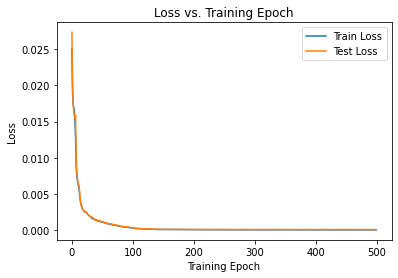

In [10]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")

plt.xlabel("Training Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Training Epoch")
plt.legend()
plt.show()


In [11]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
model = torch.load(model_save_path)
model.eval()

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        for a, b in zip(pred.cpu().numpy(), y.cpu().numpy()):
            print(a, b)
        

[0.11 0.11 0.11 0.09 0.10 0.09 0.10 0.10 0.10 0.08] [0.11 0.11 0.10 0.10 0.09 0.09 0.09 0.11 0.11 0.09]
[0.00 0.00 0.93 0.00 0.00 0.00 0.00 0.00 0.00 0.06] [0.00 0.00 0.91 0.00 0.00 0.00 0.01 0.00 0.00 0.08]
[0.07 0.27 0.04 0.01 0.03 0.12 0.08 0.00 0.10 0.29] [0.05 0.26 0.05 0.01 0.01 0.12 0.08 0.00 0.09 0.32]
[0.03 0.17 0.12 0.13 0.25 0.04 0.05 0.08 0.07 0.07] [0.02 0.18 0.13 0.13 0.24 0.05 0.04 0.09 0.05 0.07]
[0.13 0.11 0.01 0.08 0.46 0.00 0.01 0.13 0.03 0.03] [0.14 0.12 0.01 0.09 0.40 0.00 0.02 0.15 0.04 0.04]
[0.09 0.09 0.11 0.10 0.10 0.10 0.10 0.10 0.11 0.09] [0.09 0.09 0.12 0.10 0.10 0.10 0.08 0.11 0.11 0.09]
[0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00] [0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00]
[0.11 0.09 0.09 0.10 0.10 0.10 0.10 0.10 0.10 0.10] [0.10 0.09 0.11 0.10 0.10 0.09 0.11 0.10 0.10 0.10]
[0.00 0.00 0.00 0.99 0.00 0.00 0.00 0.00 0.00 0.00] [0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00]
[0.72 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.28 0.00] [0.70 0.03 0

[0.08 0.11 0.10 0.11 0.11 0.12 0.09 0.11 0.06 0.10] [0.07 0.11 0.13 0.10 0.11 0.12 0.08 0.11 0.06 0.11]
[0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00] [0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00]
[0.04 0.11 0.04 0.01 0.03 0.20 0.16 0.15 0.02 0.23] [0.04 0.11 0.04 0.00 0.06 0.21 0.14 0.15 0.01 0.23]
[0.07 0.16 0.08 0.06 0.15 0.09 0.09 0.10 0.08 0.12] [0.06 0.18 0.08 0.06 0.13 0.10 0.09 0.12 0.08 0.11]
[0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00] [0.00 0.00 0.99 0.00 0.00 0.00 0.00 0.00 0.01 0.00]
[0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00] [0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00]
[0.22 0.06 0.14 0.26 0.13 0.10 0.01 0.05 0.00 0.02] [0.20 0.08 0.15 0.25 0.12 0.12 0.01 0.06 0.01 0.01]
[0.11 0.10 0.09 0.10 0.11 0.09 0.10 0.08 0.11 0.11] [0.10 0.09 0.10 0.11 0.11 0.09 0.10 0.10 0.10 0.11]
[0.09 0.11 0.11 0.09 0.10 0.10 0.09 0.09 0.13 0.10] [0.08 0.11 0.10 0.10 0.10 0.10 0.09 0.08 0.14 0.09]
[0.10 0.11 0.07 0.06 0.11 0.13 0.14 0.05 0.10 0.15] [0.09 0.12 0

[1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00] [1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00] [0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
[0.20 0.02 0.29 0.01 0.09 0.01 0.03 0.05 0.05 0.27] [0.19 0.03 0.28 0.01 0.10 0.00 0.02 0.05 0.04 0.27]
[0.00 0.00 0.04 0.04 0.01 0.42 0.01 0.00 0.48 0.00] [0.00 0.00 0.05 0.03 0.00 0.41 0.03 0.00 0.47 0.00]
[0.11 0.10 0.11 0.10 0.10 0.09 0.10 0.10 0.10 0.10] [0.11 0.09 0.12 0.11 0.09 0.08 0.10 0.12 0.09 0.10]
[0.11 0.10 0.10 0.09 0.11 0.11 0.10 0.10 0.10 0.10] [0.11 0.10 0.09 0.08 0.09 0.10 0.11 0.11 0.11 0.10]
[0.01 0.01 0.00 0.01 0.29 0.00 0.07 0.00 0.00 0.60] [0.01 0.01 0.00 0.01 0.29 0.00 0.07 0.00 0.00 0.62]
[0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.99 0.00] [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00]
[0.20 0.00 0.00 0.21 0.17 0.34 0.00 0.00 0.06 0.01] [0.22 0.01 0.00 0.20 0.16 0.35 0.00 0.00 0.06 0.01]
[0.11 0.09 0.12 0.12 0.09 0.09 0.07 0.10 0.11 0.09] [0.10 0.09 0

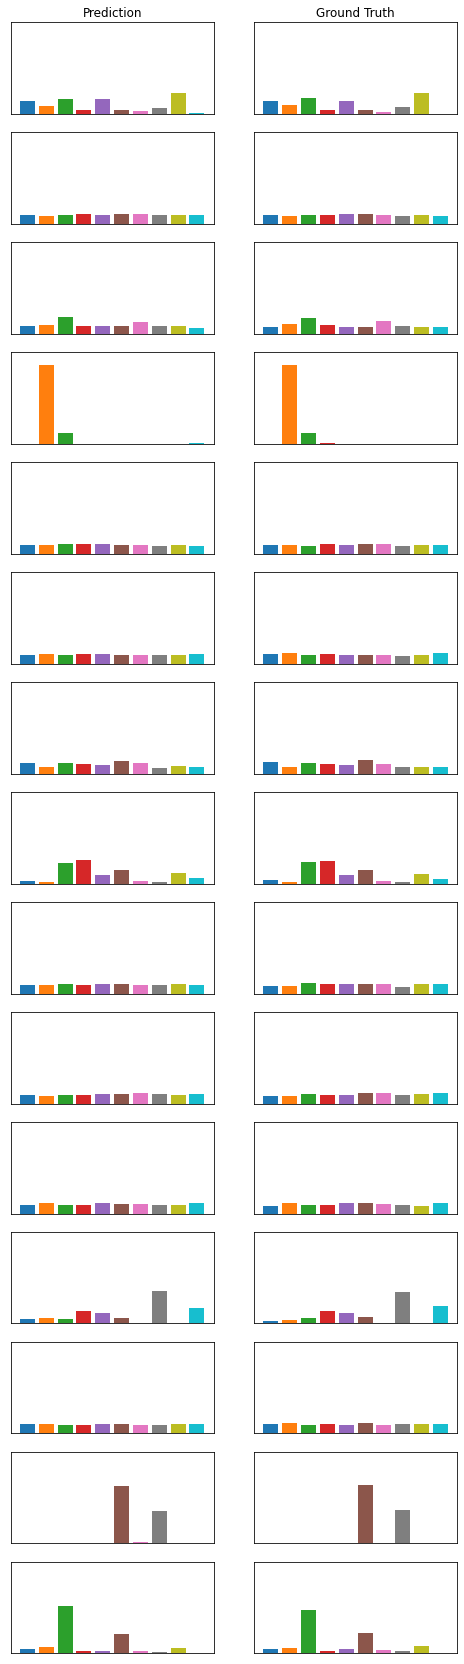

In [13]:
num_plots = 15

fig, axs = plt.subplots(num_plots, 2, figsize=(8, num_plots * 2))

cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(10)]

for i in range(num_plots):
    axs[i][0].bar(range(10), pred[i].cpu().numpy(), color=colors)
    axs[i][0].set_ylim(0, 1)
    axs[i][0].set_xticks([])
    axs[i][0].set_yticks([])
    axs[i][1].bar(range(10), y[i].cpu().numpy(), color=colors)
    axs[i][1].set_ylim(0, 1)
    axs[i][1].set_xticks([])
    axs[i][1].set_yticks([])
    
axs[0, 0].set_title("Prediction")
axs[0, 1].set_title("Ground Truth")

plt.savefig("Distribution Comparison CIFAR")